In [1]:
import carla 
import math 
import random 
import time 
import numpy as np
import cv2
from PIL import Image
# Connect the client and set up bp library and spawn points
client = carla.Client('localhost', 2000) 
world = client.get_world()
bp_lib = world.get_blueprint_library()  
spawn_points = world.get_map().get_spawn_points() 

In [2]:
def depthimage(rgb,depthmap):
    R = rgb[:,:,0]
    G = rgb[:,:,1]
    B = rgb[:,:,2]

    normalized = (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1)
    in_meters = 1000 * normalized
    in_meters = in_meters.reshape((in_meters.shape[0], in_meters.shape[1], 1))
    # output = np.concatenate([rgb[:,:,:3], in_meters],axis = 2)
    # return output
    return in_meters


In [3]:
# Add the ego vehicle
vehicle_bp = bp_lib.find('vehicle.lincoln.mkz_2020') 
vehicle = world.try_spawn_actor(vehicle_bp, spawn_points[79])

# Move the spectator behind the vehicle to view it
# spectator = world.get_spectator() 
transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-4,z=2.5)),vehicle.get_transform().rotation) 
# spectator.set_transform(transform)


In [4]:
# Set initial camera translation
camera_init_trans = carla.Transform(carla.Location(z=2),carla.Rotation(pitch=180))

# Add one of each type of camera
camera_bp = bp_lib.find('sensor.camera.rgb') 
camera = world.spawn_actor(camera_bp, camera_init_trans, attach_to=vehicle)

depth_camera_bp = bp_lib.find('sensor.camera.depth') 
depth_camera = world.spawn_actor(depth_camera_bp, camera_init_trans, attach_to=vehicle)

lidar_bp = bp_lib.find('sensor.lidar.ray_cast')
lidar = world.spawn_actor(lidar_bp, camera_init_trans, attach_to=vehicle)


In [5]:
# lidar = world.spawn_actor(lidar_bp, camera_init_trans, attach_to=vehicle)


In [15]:
# Define respective callbacks
def rgb_callback(image, data_dict):
    data_dict['rgb_image'] = np.reshape(np.copy(image.raw_data), (image.height, image.width, 4))
    # image.save_to_disk('rgb_out/%06d.png' % image.frame)
def depth_callback(image, data_dict):
    image.convert(carla.ColorConverter.LogarithmicDepth)
    data_dict['depth_image'] = np.reshape(np.copy(image.raw_data), (image.height, image.width, 4))
def lidar_callback(data, data_dict):
    data_dict['lidar_data'] = np.copy(data.raw_data)
    print('shape raw data', data.raw_data.shape)
    # data.save_to_disk('lidar_out/%06d.ply' % data.frame)
    

In [16]:
dict = {}
# dict['get_transform']  = []

In [17]:
# Initialise parameters and data
image_w = camera_bp.get_attribute("image_size_x").as_int()
image_h = camera_bp.get_attribute("image_size_y").as_int()


sensor_data = {'rgb_image': np.zeros((image_h, image_w, 4)),
               'depth_image': np.zeros((image_h, image_w, 4)),
               'lidar_data': np.zeros((image_h, image_w, 4))}

# OpenCV named window for display
# cv2.namedWindow('All cameras', cv2.WINDOW_NORMAL)

# Tile all data in one array
top_row = sensor_data['rgb_image']
lower_row = sensor_data['depth_image']
tiled = np.concatenate((top_row, lower_row), axis=0)

# Display with imshow
# cv2.imshow('All cameras',sensor_data['rgb_image'])
# cv2.waitKey(1)
# world.get_actor().set_autopilot(True)
vehicle.set_autopilot(True)
# Set sensors recording
camera.listen(lambda image: rgb_callback(image, sensor_data))
depth_camera.listen(lambda image: depth_callback(image, sensor_data))
lidar.listen(lambda data: lidar_callback(data, sensor_data))
# Build the intrinsic matrix:
# K = [[Fx,  0, image_w/2],
#      [ 0, Fy, image_h/2],
#      [ 0,  0,         1]]
# image_w = camera.get_attribute("image_size_x").as_int()
# image_h = camera.get_attribute("image_size_y").as_int()
fov = camera_bp.get_attribute("fov").as_float()
focal = image_w / (2.0 * np.tan(fov * np.pi / 360.0))

# In this case Fx and Fy are the same since the pixel aspect
# ratio is 1
K = np.identity(3)
K[0, 0] = K[1, 1] = focal
K[0, 2] = image_w / 2.0
K[1, 2] = image_h / 2.0
# depthimage(sensor_data['rgb_image'],sensor_data['depth_image'])
# Indefinite while loop
# while True:
dict = {'intrinsic':K,'extrinsic':[],'depth':[],'rgb':[],'position':[],'get_transfrom':[],'lidar':[]}
for i in range(0,10):
    
    # Tile camera images into one array
    top_row = sensor_data['rgb_image']
    lower_row = sensor_data['depth_image']
    tiled = np.concatenate((top_row, lower_row), axis=1)
    print(camera.get_transform().location.x)

    # depth = depthimage(sensor_data['rgb_image'],sensor_data['depth_image'])
    depth = sensor_data['depth_image']
    lidar_data = sensor_data['lidar_data']
    # Dispaly with imshow
    # cv2.imshow('All cameras',tiled)
    # i += 1
    # Break loop if user presses q
    # if cv2.waitKey(1) == ord('q'):
    #     break
    # top_row.save_to_disk('rgb_out/%06d.png' % i)
    
    # This (4, 4) matrix transforms the points from world to sensor coordinates.
    world_2_camera = np.array(camera.get_transform().get_inverse_matrix()) # transform camera to world 

    # # New we must change from UE4's coordinate system to an "standard"
    # # camera coordinate system (the same used by OpenCV):

    # # ^ z                       . z
    # # |                        /
    # # |              to:      +-------> x
    # # | . x                   |
    # # |/                      |
    # # +-------> y             v y

    # # This can be achieved by multiplying by the following matrix:
    # # [[ 0,  1,  0 ],
    # #  [ 0,  0, -1 ],
    # #  [ 1,  0,  0 ]]

    cameraR = np.array([[0,1,0,0],[0,0,-1,0],[1,0,0,0],[0,0,0,1]])@world_2_camera
    # print("world2camera",world_2_camera)
    # print(cameraR)
    dict['depth'].append(depth)
    # dict['rgb'].append(sensor_data['rgb_image'])
    dict['extrinsic'].append(cameraR)
    dict['position'].append(np.array([camera.get_transform().location.x,camera.get_transform().location.y,camera.get_transform().location.z]))
    # image = Image.fromarray(sensor_data['rgb_image'][0,2,1,3])
    # image.save("rgb_out/%08d.png" %i)
    # print(camera.get_transform().get_matrix())
    dict['get_transfrom'].append(np.array(camera.get_transform().get_matrix()))
    dict['lidar'].append(lidar_data)
    cv2.imwrite("rgb_out_test/%03d.png"%i, sensor_data['rgb_image'])
# Stop sensors and destroy OpenCV window
camera.stop()
depth_camera.stop()
# cv2.destroyAllWindows()

36.52165603637695
36.52165603637695
36.52165603637695
36.52165603637695
shape raw data (1584,)
36.52165603637695
36.80586624145508
36.80586624145508
36.80586624145508
shape raw data (624,)
36.80586624145508
37.0777702331543


shape raw data (256,)
shape raw data (112,)
shape raw data (112,)
shape raw data (160,)
shape raw data (80,)
shape raw data (128,)
shape raw data (0,)
shape raw data (0,)
shape raw data (0,)
shape raw data (0,)
shape raw data (0,)
shape raw data (224,)
shape raw data (256,)
shape raw data (720,)
shape raw data (608,)
shape raw data (1184,)
shape raw data (2192,)
shape raw data (2912,)
shape raw data (4608,)
shape raw data (5024,)
shape raw data (5792,)
shape raw data (6752,)
shape raw data (6352,)
shape raw data (5632,)
shape raw data (5248,)
shape raw data (5504,)
shape raw data (5856,)
shape raw data (6608,)
shape raw data (8048,)
shape raw data (8864,)
shape raw data (9616,)
shape raw data (11088,)
shape raw data (11968,)
shape raw data (12288,)
shape raw data (14048,)
shape raw data (11696,)


In [9]:
import matplotlib.pyplot as plt

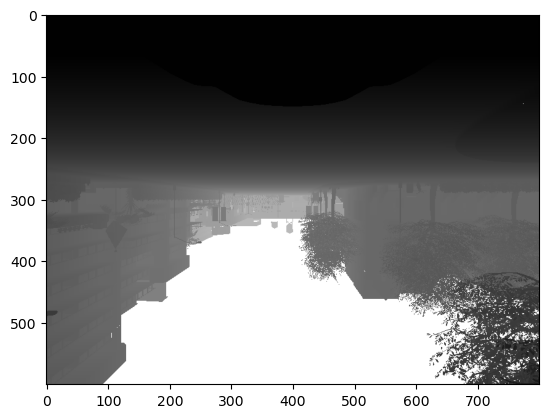

In [10]:
plt.imshow(dict['depth'][1])

In [34]:
camera.get_transform().get_matrix()

[[-0.01071504782885313,
  0.9999421238899231,
  0.0010215196525678039,
  -41.914024353027344],
 [0.9999169111251831,
  0.010722090490162373,
  -0.007157573942095041,
  -11.092316627502441],
 [-0.007168111857026815,
  0.0009447410120628774,
  -0.9999738931655884,
  1.993599772453308],
 [0.0, 0.0, 0.0, 1.0]]

In [18]:
camera.stop()
depth_camera.stop()
lidar.stop()

shape raw data (11600,)


In [26]:
# # Destroy actors
# vehicle.destroy()
# world.get_actor().filter('vehicle').destroy()

In [20]:
# dict
dict['lidar'][0].shape

(600, 800, 4)

: 

In [11]:
import pickle


with open('10frame_test.pickle', 'wb') as f:
    pickle.dump(dict, f)

RuntimeError: Pickling of "carla.libcarla.LidarDetection" instances is not enabled (http://www.boost.org/libs/python/doc/v2/pickle.html)

In [1]:
import pickle
with open('10frame.pickle', 'rb') as f:
    a = pickle.load(f)